In [2]:
import torch, cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np

class SAM2ImageProcessor:
    def __init__(self, checkpoint, model_cfg, device="cpu"):
        self.predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint, device=device))

    def process_image(self, image_data, point_coords, point_labels, multimask_output=False):
        self.predictor.set_image(image_data)
        masks, _, _ = self.predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=multimask_output,
        )
        mask_array = masks[0]

        print("point_coords: ", point_coords)
        print("point_labels: ", point_labels)

        # 使用OpenCV实现Halcon的fill_up功能
        mask_uint8 = (mask_array * 255).astype(np.uint8)
        cv2.imwrite("mask_uint8.bmp", mask_uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        filled_image = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)

        # 去除面积小于500的连通域
        num_labels, labels_im = cv2.connectedComponents(filled_image)
        label_sizes = np.bincount(labels_im.ravel())
        small_labels = np.where(label_sizes < 500)[0]
        for label in small_labels:
            filled_image[labels_im == label] = 0

        # 使用Canny算子获取mask的边缘
        edges = cv2.Canny(filled_image, 100, 200)

        return edges

point_coords:  [[1156, 1823], [1960, 1606], [2858, 1538], [2912, 2245], [2776, 3266], [1769, 3416], [1252, 2885], [843, 2708], [639, 3661], [1538, 4246], [2341, 4437], [3375, 4015], [3675, 2014], [2028, 803], [830, 1306], [258, 1769], [3647, 1197]]
point_labels:  [1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


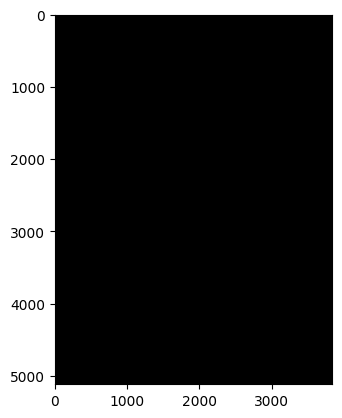

In [3]:
import matplotlib.pyplot as plt

checkpoint = "D:/python/sam2_label/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg  = "D:/python/sam2_label/sam2/configs/sam2.1/sam2.1_hiera_b+.yaml"
image_path = 'E:/dataset/鲫鱼/200_00fb306e03d311f5c33830ab89f65c5b.jpg'
image_data = Image.open(image_path)
numpy_image = np.array(image_data)

processor = SAM2ImageProcessor(checkpoint, model_cfg)

contours_pts = [[1156, 1823],[1960, 1606],[2858, 1538],[2912, 2245],
                [2776, 3266],[1769, 3416],[1252, 2885],[ 843, 2708],
                [ 639, 3661],[1538, 4246],[2341, 4437],[3375, 4015],
                [3675, 2014],[2028,  803],[ 830, 1306],[ 258, 1769],
                [3647, 1197]]
labels = [ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,]

contours = processor.process_image(image_data, point_coords=contours_pts, point_labels=labels)
uint8_array = (contours * 255).astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))
filled_image = cv2.morphologyEx(uint8_array, cv2.MORPH_CLOSE, kernel)

edges = cv2.Canny(filled_image, 100, 200)
numpy_image[edges > 0] = [0, 0, 255]

plt.imshow(edges, cmap='gray')